In [12]:
import json
import requests
import torch
import random
import numpy as np
from torchvision import models, transforms
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
# Load ImageNet class index if not already available
URL = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
class_idx = requests.get(URL).json()

# Function to get class label from class index
def get_class_label(idx):
    return class_idx[str(idx)][1]


In [13]:
# Function to get class label from class index
def get_class_label(idx):
    return class_idx[str(idx)][1]

def random_classifier(x):
    return torch.rand((1, 1000), requires_grad=True)  # Changed function name and output size

def adversarial_loss(output, target):
    target_score = output[0, target]
    return -target_score

def draw_mask(center, rays, angles, image_size):
    image = Image.new('L', image_size, 0)
    draw = ImageDraw.Draw(image)
    for angle, ray in zip(angles, rays):
        end_x = int(center[0] + ray * np.cos(angle))
        end_y = int(center[1] + ray * np.sin(angle))
        draw.line([center, (end_x, end_y)], fill=255, width=5)  # Decreased line width
    return np.array(image)


In [17]:
def generate_adversarial_patch(target_class, iterations=5000, lr=0.1):

    # Load VGG19 model
    vgg19 = models.vgg19(pretrained=True).eval()
    if torch.cuda.is_available():
        vgg19 = vgg19.cuda()

    # Parameters
    h, w = 256, 256  # Image dimensions
    centerx, centery = 128, 128  # Top-left corner of the patch
    num_regions = 18  # Number of sectors
    r = torch.abs(torch.randn(1, num_regions) * 15 + 15)  # Random radii

    # Initialize a patch with random gradients
    initial_patch = torch.rand(3, h, w, requires_grad=False)  # RGB channels, height, width

    # Create coordinate grid
    x = torch.arange(w).repeat(h, 1).float()
    y = torch.arange(h).unsqueeze(1).repeat(1, w).float()

    # Compute distances and angles from the new origin (top-left corner)
    dx = x - centerx
    dy = y - centery
    distance = torch.sqrt(dx**2 + dy**2)
    angle = torch.atan2(dy, dx) * 180 / np.pi
    angle[angle < 0] += 360

    # Segment into regions and apply mask
    sector_angles = torch.linspace(0, 360, num_regions + 1)[:-1]
    output_patch = torch.zeros_like(initial_patch)  # Create a zero tensor for output

    for i, start_angle in enumerate(sector_angles):
        end_angle = sector_angles[(i + 1) % num_regions] if (i + 1) < num_regions else 360
        in_sector = (angle >= start_angle) & (angle < end_angle) & (distance <= r[0, i])
        mask = in_sector.unsqueeze(0).repeat(3, 1, 1)  # Repeat for RGB channels

        # Apply the original gradient within each sector
        output_patch[:, mask[0]] = initial_patch[:, mask[0]]

    # Detach the output patch to make it a leaf tensor
    output_patch = output_patch.detach()

    # Generate the initial random patch
    patch = output_patch.requires_grad_(True)  # Enable gradient tracking on the patch

    # Define the optimizer
    optimizer = optim.SGD([patch], lr=lr, momentum=0.9)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Optimize the patch
    for i in range(iterations):
        optimizer.zero_grad()  # Zero-out the gradients to avoid accumulation

        # Forward pass: compute the predicted output by VGG19
        output = vgg19(patch.unsqueeze(0))  # Add batch dimension

        # Calculate loss: maximize the probability of the target class
        loss = -criterion(output, torch.tensor([target_class]).to(output.device))  # Negative loss for ascent

        # Backward pass: compute gradient of the loss with respect to the patch
        loss.backward()

        # Update the patch
        optimizer.step()

        # Optional: print progress
        print(f'Iteration {i+1}, Loss: {loss.item()}')

    # Detach the optimized patch from the graph
    optimized_patch = patch.detach()

    # Convert optimized patch tensor to numpy array
    patch_array = optimized_patch.permute(1, 2, 0).cpu().numpy()

    return patch_array

In [18]:
def load_image(image_path):
    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((300, 300)),  # Resized image for better visualization
        transforms.ToTensor()
    ])
    return transform(img).unsqueeze(0)

In [10]:
# Load VGG model
model = models.vgg16(pretrained=True)
model.eval()

# Load and prepare the image
image_path = input("\nEnter Your image name or path: ")
input_image = load_image(image_path)



Enter Your image name or path:  car.jpg


In [29]:
# Predict original image
original_output = model(input_image)
original_class = original_output.argmax().item()
original_label = get_class_label(original_class)

# Generate and apply the patch
target_class = 450  # Target class for the adversarial patch
patch = generate_adversarial_patch(target_class, iterations=10, lr=0.05)  # Increased iterations and adjusted lr
patch = torch.tensor(patch).permute(2, 0, 1)  # Convert patch to tensor and permute dimensions
patch = transforms.Resize((300, 300))(patch)  # Resize patch to match input image size
patched_image = input_image + patch  # Add patch to input image


Iteration 1, Loss: -10.3717622756958
Iteration 2, Loss: -10.960891723632812
Iteration 3, Loss: -12.109381675720215
Iteration 4, Loss: -13.660483360290527
Iteration 5, Loss: -15.660541534423828
Iteration 6, Loss: -18.568096160888672
Iteration 7, Loss: -21.832382202148438
Iteration 8, Loss: -24.519975662231445
Iteration 9, Loss: -27.827260971069336
Iteration 10, Loss: -34.56040954589844


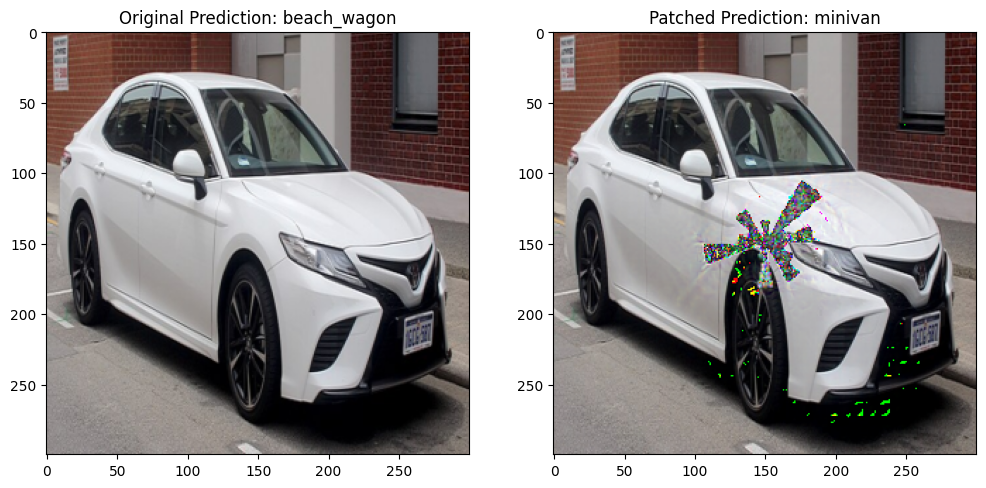

In [28]:
# Predict patched image
patched_output = model(patched_image)
patched_class = patched_output.argmax().item()
patched_label = get_class_label(patched_class)

# Save patched image
save_img = transforms.ToPILImage()(patched_image.squeeze(0))
save_img.save("patched_image.jpg")

# Display results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(transforms.ToPILImage()(input_image.squeeze(0)))
ax[0].set_title(f"Original Prediction: {original_label}")
ax[1].imshow(save_img)
ax[1].set_title(f"Patched Prediction: {patched_label}")
plt.show()